In [1]:
import os 
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import cv2
from PIL import Image

from tqdm.notebook import tqdm
import time

tqdm.pandas()

plt.rcParams["font.family"] = "Times New Roman"
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)


#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#tf.config.threading.set_intra_op_parallelism_threads(num_threads=10)

In [2]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
df = pd.read_csv('train_2_0.csv')
df2 = df.drop(df.columns[1:-2],axis=1)
df2

,Id,Pawpularity,path
0,0007de18844b0dbbb5e1f607da0606e0,63,data/train/0007de18844b0dbbb5e1f607da0606e0.jpg
1,0009c66b9439883ba2750fb825e1d7db,42,data/train/0009c66b9439883ba2750fb825e1d7db.jpg
2,0013fd999caf9a3efe1352ca1b0d937e,28,data/train/0013fd999caf9a3efe1352ca1b0d937e.jpg
3,0018df346ac9c1d8413cfcc888ca8246,15,data/train/0018df346ac9c1d8413cfcc888ca8246.jpg
4,001dc955e10590d3ca4673f034feeef2,72,data/train/001dc955e10590d3ca4673f034feeef2.jpg
...,...,...,...
9851,ffbfa0383c34dc513c95560d6e1fdb57,15,data/train/ffbfa0383c34dc513c95560d6e1fdb57.jpg
9852,ffcc8532d76436fc79e50eb2e5238e45,70,data/train/ffcc8532d76436fc79e50eb2e5238e45.jpg
9853,ffdf2e8673a1da6fb80342fa3b119a20,20,data/train/ffdf2e8673a1da6fb80342fa3b119a20.jpg
9854,fff19e2ce11718548fa1c5d039a5192a,20,data/train/fff19e2ce11718548fa1c5d039a5192a.jpg


In [14]:
#переводит изображение в тензор
# path - путь к изображению
# img_w - выходная ширина изображения
# img_h - выходная высота изображения
def prep_image(path, img_w, img_h):
    orig_img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(orig_img, channels=3)
    img = tf.cast(img, dtype=tf.float32) / 255.0
    img = tf.image.resize(img, (img_w, img_h))
    return img

In [ ]:
example_image = plt.imread(df2['path'][0])
plt.title('Изображение до обработки')
plt.imshow(example_image)
print(example_image.shape)

In [ ]:
prep_example_img = prep_image(df2['path'][0], 128,128)
plt.title('после обработки')
plt.imshow(prep_example_img)
print(prep_example_img.shape)

In [ ]:
paths = df2.path
X = np.array([prep_image(p, 128, 128) for p in paths])
print(X.shape)

In [ ]:
fig,ax = plt.subplots(1,5, figsize=(15,15))
for i in range(5):
    img=plt.imread(df.path[i])
    ax[i].imshow(img)
    ax[i].set_title(f"Популярность: {df.Pawpularity[i]}")
    ax[i].set_xlabel(img.shape)


In [ ]:
fig,ax = plt.subplots(1,5, figsize=(15,15))
for i in range(5):
    ax[i].imshow(X[i])
    ax[i].set_title(f"Популярность: {df.Pawpularity[i]}")
    ax[i].set_xlabel(X[i].shape)


In [3]:
#np.save(file='X', arr=X)
#with tf.device("CPU"):
X = np.load('X.npy')
Y = df2.Pawpularity / 100


In [4]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0) 

In [5]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(8870, 128, 128, 3)
(8870,)
(986, 128, 128, 3)
(986,)


In [6]:
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, InputLayer

## Первая модель

In [7]:
model11 = Sequential(layers=[
    InputLayer(input_shape=(X_train.shape[1],X_train.shape[2], X_train.shape[3])),
    Conv2D(32, (4,4), padding='same',activation='relu'),
    MaxPooling2D(padding='same'),
    Conv2D(64, (4,4), padding='same',activation='relu'),
    # MaxPooling2D(padding='same'),
    # Conv2D(128, (2,2), padding='same',activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(1)
],
name='cnn.1'
)

In [8]:
model11.summary()

Model: "cnn.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        32832     
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 dense (Dense)               (None, 128)               33554560  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                             

In [9]:
model11.compile(optimizer='adam', loss=keras.losses.mean_squared_error, metrics=[keras.metrics.mean_absolute_error, 
                                                                                keras.metrics.RootMeanSquaredError(),
                                                                                ])

In [ ]:
#with tf.devices('CPU'):
history1 = model11.fit(
                         X_train,
                         Y_train,
                         epochs=25,
                         verbose=1,
                         validation_split=0.2,
                         batch_size=16,
                         )

Epoch 1/25


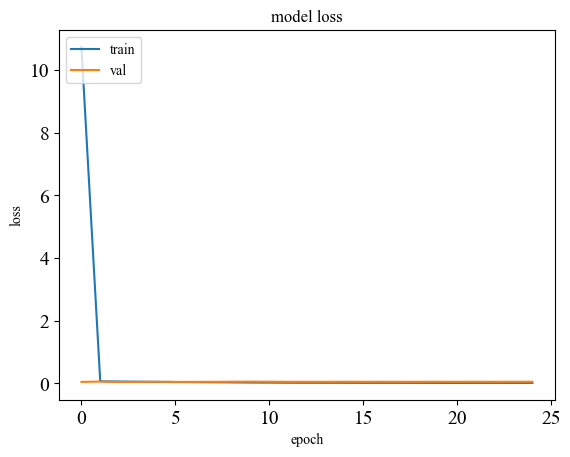

In [16]:
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

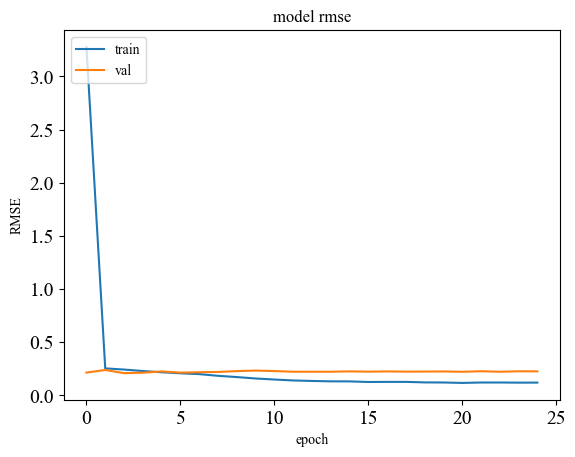

In [17]:
# summarize history for loss
plt.plot(history1.history['root_mean_squared_error'])
plt.plot(history1.history['val_root_mean_squared_error'])
plt.title('model rmse')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
import gc 
gc.collect()

2754

In [31]:
with tf.device('CPU'):
    model11.evaluate(X_train, Y_train)
    model11.evaluate(X_test, Y_test)

62/62 [==============================] - 5s 85ms/step - loss: 0.0508 - mean_absolute_error: 0.1671 - root_mean_squared_error: 0.2254


In [21]:
with tf.device('CPU'):
    pred1=model11.predict(X_test)

62/62 [==============================] - 6s 89ms/step


In [22]:
pred1

array([[0.31090122],
       [0.2928108 ],
       [0.37977618],
       ...,
       [0.2825635 ],
       [0.24148156],
       [0.548228  ]], dtype=float32)

In [23]:
df_res = pd.DataFrame(data=Y_test)
df_res['model1_pred'] = pred1

In [24]:
df_res

,Pawpularity,model1_pred
3239,0.02,0.310901
7035,0.22,0.292811
600,0.31,0.379776
5098,0.59,0.290146
9631,0.45,0.506704
...,...,...
5520,0.27,0.295741
2670,0.75,0.323444
2256,0.22,0.282564
2722,0.16,0.241482


<Axes: xlabel='Pawpularity', ylabel='model1_pred'>

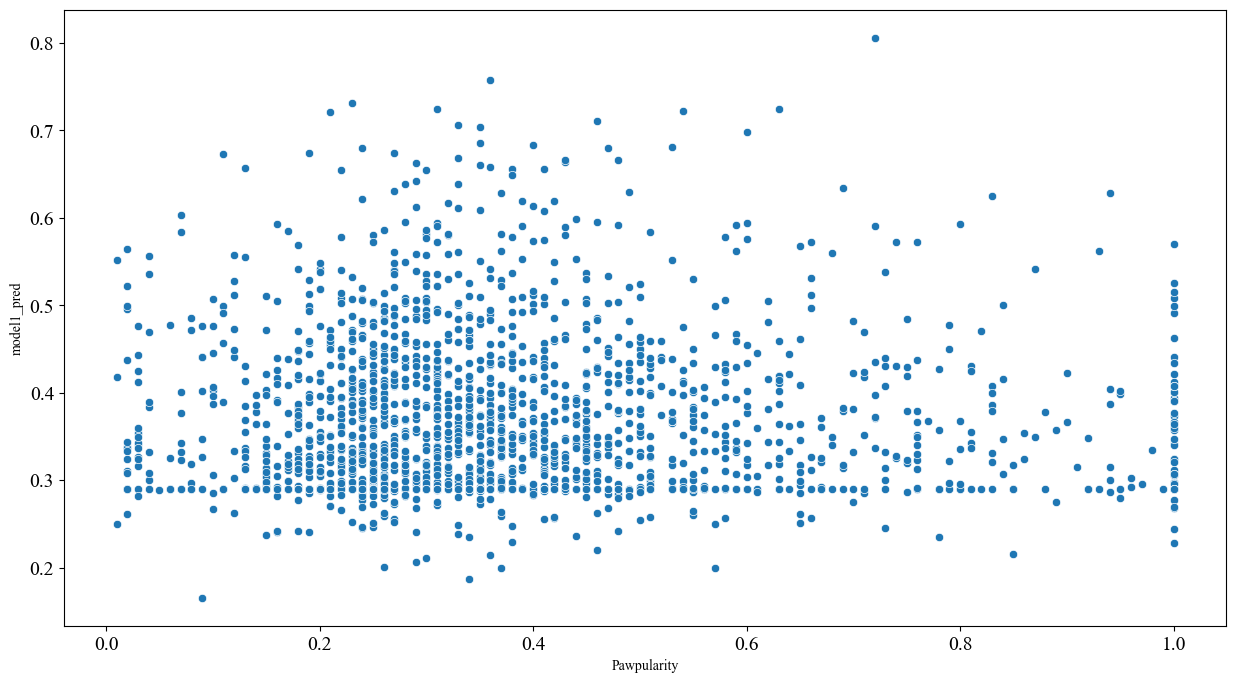

In [30]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df_res, x=df_res['Pawpularity'], y=df_res['model1_pred'], markers=True)

In [33]:
del model11

NameError: name 'model11' is not defined

In [35]:
gc.collect()

0

## Вторая модель

In [ ]:
model2 = Sequential(
    
)